## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.4]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 22:24:29.742683  7520 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 22:24:29.745683  7520 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 22:24:29.765684  7520 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 22:24:29.893692  7520 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5


W0723 22:24:30.253712  7520 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 22:24:30.265713  7520 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0723 22:24:30.361718  7520 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 10s 195us/step - loss: 1.2553 - acc: 0.5650 - val_loss: 1.4831 - val_acc: 0.4780
Epoch 14/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.2343 - acc: 0.5713 - val_loss: 1.4766 - val_acc: 0.4801
Epoch 15/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.2141 - acc: 0.5802 - val_loss: 1.4750 - val_acc: 0.4824
Epoch 16/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.1937 - acc: 0.5848 - val_loss: 1.4757 - val_acc: 0.4831
Epoch 17/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.1739 - acc: 0.5955 - val_loss: 1.4764 - val_acc: 0.48382s - loss: 1.174
Epoch 18/25
50000/50000 [==============================] - 10s 196us/step - loss: 1.1559 - acc: 0.6008 - val_loss: 1.4665 - val_acc: 0.4882
Epoch 19/25
50000/50000 [==============================] - 10s 197us/step - loss: 1.1382 - acc: 0.6087 - val_loss: 1.4665 - val_acc: 0.4891
Epoch 20/25
5000

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 190us/step - loss: 2.3623 - acc: 0.2336 - val_loss: 2.2900 - val_acc: 0.2592
Epoch 2/25
50000/50000 [==============================] - 10s 194us/step - loss: 1.8971 - acc: 0.3467 - val_loss: 1.9439 - val_acc: 0.3286
Epoch 3/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.7496 - acc: 0.3859 - val_loss: 1.8224 - val_acc: 0.3683
Epoch 4/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.6698 - acc: 0.4132 - val_loss: 1.7230 - val_acc: 0.3995
Epoch 5/25
50000/50000 [==============================] - 10s 197us/step - loss: 1.6136 - acc: 0.4332 - val_loss: 1.6914 - val_acc: 0.4107
Epoch 6/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.5700 - acc: 0.4487 - val_loss: 1.6553 - val_acc: 0.4214
Epoch 7/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.5325 - acc: 0.4605 - val_loss: 1.6

50000/50000 [==============================] - 10s 205us/step - loss: 0.4075 - acc: 0.8810 - val_loss: 1.6182 - val_acc: 0.5128
Epoch 23/25
50000/50000 [==============================] - 10s 205us/step - loss: 0.3754 - acc: 0.8964 - val_loss: 1.5992 - val_acc: 0.5063
Epoch 24/25
50000/50000 [==============================] - 10s 204us/step - loss: 0.3550 - acc: 0.9044 - val_loss: 1.6121 - val_acc: 0.5213
Epoch 25/25
50000/50000 [==============================] - 10s 204us/step - loss: 0.3380 - acc: 0.9100 - val_loss: 1.6470 - val_acc: 0.5130
Numbers of exp: 5, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_______________________________________________________________

50000/50000 [==============================] - 10s 206us/step - loss: 1.2079 - acc: 0.5814 - val_loss: 1.4915 - val_acc: 0.4670
Epoch 9/25
50000/50000 [==============================] - 10s 205us/step - loss: 1.1778 - acc: 0.5933 - val_loss: 1.4723 - val_acc: 0.4823
Epoch 10/25
50000/50000 [==============================] - 10s 205us/step - loss: 1.1497 - acc: 0.6045 - val_loss: 1.4290 - val_acc: 0.4994
Epoch 11/25
50000/50000 [==============================] - 10s 208us/step - loss: 1.1247 - acc: 0.6122 - val_loss: 1.4402 - val_acc: 0.4946
Epoch 12/25
50000/50000 [==============================] - 11s 218us/step - loss: 1.0992 - acc: 0.6227 - val_loss: 1.4222 - val_acc: 0.4968
Epoch 13/25
50000/50000 [==============================] - 11s 220us/step - loss: 1.0766 - acc: 0.6306 - val_loss: 1.4259 - val_acc: 0.4949
Epoch 14/25
50000/50000 [==============================] - 10s 209us/step - loss: 1.0552 - acc: 0.6409 - val_loss: 1.4288 - val_acc: 0.5017
Epoch 15/25
50000/50000 [========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 269us/step - loss: 1.8245 - acc: 0.3681 - val_loss: 2.1963 - val_acc: 0.2936
Epoch 2/25
50000/50000 [==============================] - 10s 203us/step - loss: 1.5350 - acc: 0.4535 - val_loss: 2.0129 - val_acc: 0.3254
Epoch 3/25
50000/50000 [==============================] - 10s 204us/step - loss: 1.4130 - acc: 0.4995 - val_loss: 1.7503 - val_acc: 0.4011
Epoch 4/25
50000/50000 [==============================] - 10s 202us/step - loss: 1.3315 - acc: 0.5282 - val_loss: 2.6635 - val_acc: 0.2748
Epoch 5/25
50000/50000 [==============================] - 10s 203us/step - loss: 1.2643 - acc: 0.5531 - val_loss: 2.0530 - val_acc: 0.3499
Epoch 6/25
50000/50000 [==============================] - 10s 201us/step - loss: 1.2041 - acc: 0.5730 - val_loss: 2.3974 - val_acc: 0.3270
Epoch 7/25
50000/50000 [==============================] - 10s 201us/step - loss: 1.1605 - acc: 0.5893 - val_loss: 1.

Epoch 22/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.7242 - acc: 0.7673 - val_loss: 1.5223 - val_acc: 0.4931
Epoch 23/25
50000/50000 [==============================] - 10s 200us/step - loss: 0.7093 - acc: 0.7731 - val_loss: 1.5506 - val_acc: 0.4932
Epoch 24/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.6943 - acc: 0.7777 - val_loss: 1.4731 - val_acc: 0.5079
Epoch 25/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.6777 - acc: 0.7850 - val_loss: 1.5177 - val_acc: 0.5005

Epoch 00025: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Numbers of exp: 10, reduce_factor: 0.40, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2

Epoch 8/25
50000/50000 [==============================] - 10s 203us/step - loss: 1.5202 - acc: 0.4697 - val_loss: 1.6367 - val_acc: 0.4306
Epoch 9/25
50000/50000 [==============================] - 10s 204us/step - loss: 1.4884 - acc: 0.4813 - val_loss: 1.6220 - val_acc: 0.4342
Epoch 10/25
50000/50000 [==============================] - 10s 207us/step - loss: 1.4610 - acc: 0.4917 - val_loss: 1.5973 - val_acc: 0.4379
Epoch 11/25
50000/50000 [==============================] - 10s 204us/step - loss: 1.4346 - acc: 0.5018 - val_loss: 1.5857 - val_acc: 0.4470
Epoch 12/25
50000/50000 [==============================] - 10s 204us/step - loss: 1.4111 - acc: 0.5098 - val_loss: 1.5773 - val_acc: 0.4442
Epoch 13/25
50000/50000 [==============================] - 10s 207us/step - loss: 1.3901 - acc: 0.5160 - val_loss: 1.5626 - val_acc: 0.4506
Epoch 14/25
50000/50000 [==============================] - 10s 209us/step - loss: 1.3680 - acc: 0.5243 - val_loss: 1.5443 - val_acc: 0.4555
Epoch 15/25
50000/5000

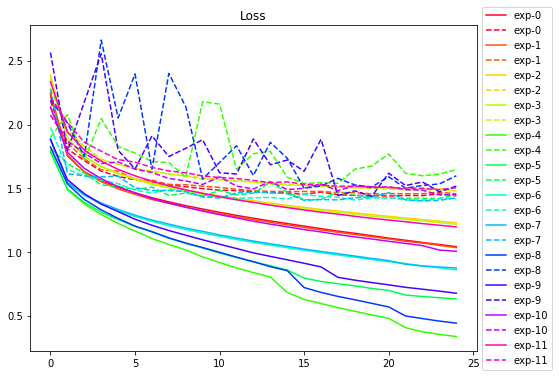

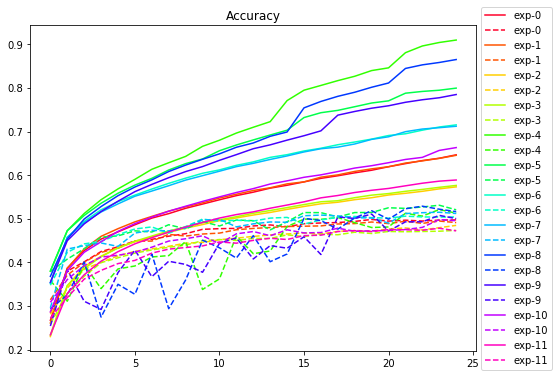

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()